# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

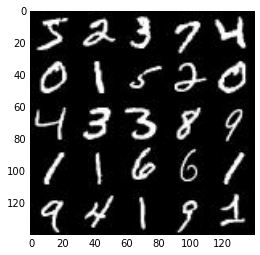

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

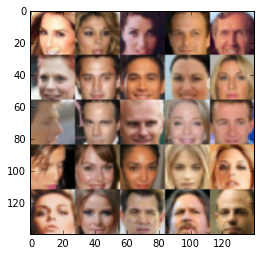

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, [], name='learning_rate')    
    return input_real, input_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # leakyness of leaky relu
    alpha = 0.1
    dropout_rate = 0.3   # 0.5 is my goto-dropout that always seems to work 
                         # however, I read, due to batch norm this can be decreased
                         # turns out, less is more. results are better with less dropout
    
    with tf.variable_scope('discriminator', reuse=reuse):   
        # three conv layers, doubling number of features each
        x1 = tf.layers.conv2d(images, filters=64, kernel_size=5, strides=2, padding='same')
        x1 = tf.maximum(alpha* x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, filters=128, kernel_size=5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(x2, filters=256, kernel_size=5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        # 4x4x256
        
        # one dropout at the end of convolutions
        dropout = tf.layers.dropout(x3, rate=dropout_rate)

        # aaaand finally one fully connected layer with sigmoid activation function
        fc1 = tf.reshape(dropout, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(fc1, 1)
        outputs = tf.sigmoid(logits)
        
    return outputs, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # leakyness of leaky relu
    alpha = 0.1
    dropout_rate = 0.3   # 0.5 is my default that always seems to work 
                         # however, I read, due to batch norm this can be decreased 
    
    # 28x28 is tricky to achieve by doubling. we have to start with 7
    with tf.variable_scope('generator', reuse=not is_train): 
        x1 = tf.layers.dense(z, 7 * 7 * 256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256
                
        x2 = tf.layers.conv2d_transpose(x1, filters=128, kernel_size=5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128

        # to keep the number of layers symmetrical, we do a stride-1-convolution here
        x3 = tf.layers.conv2d_transpose(x2, filters=64, kernel_size=5, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x64
        
        # add one dropout before the final layer
        dropout = tf.layers.dropout(x3, rate=dropout_rate)
        
        # and convolute up to desired image size
        logits = tf.layers.conv2d_transpose(dropout, filters=out_channel_dim, kernel_size=5, strides=2, padding='same')
        # (no batchnorm)
        # 28x28xout_channel_dim (probably: 28x28x3)
        outputs = tf.tanh(logits)   # activation               
        
        return outputs

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # label smoothing factor
    smoothing = 0.2

    # smooth ones for real images
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smoothing)))
    # zeros for fake images
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake

    # generated should be ones (as we're striving to generate real(-istic) images)
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    g_vars = [v for v in t_vars if v.name.startswith('generator')]
    d_vars = [v for v in t_vars if v.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    bs, width, height, channels = data_shape
    input_real, input_z, lr = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    steps_verbose_txt = 10
    steps_verbose_img = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # get images and rescale to pass to D
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                                
                if steps % steps_verbose_txt == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:0.4f}...".format(train_loss_d),
                          "Generator Loss: {:0.4f}".format(train_loss_g))

                if steps % steps_verbose_img == 0:
                    show_generator_output(sess, show_n_images, input_z, channels, data_image_mode)



### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 4.9026... Generator Loss: 10.9557
Epoch 1/2... Discriminator Loss: 0.9622... Generator Loss: 1.2226
Epoch 1/2... Discriminator Loss: 1.0084... Generator Loss: 1.6238
Epoch 1/2... Discriminator Loss: 0.9246... Generator Loss: 2.2988
Epoch 1/2... Discriminator Loss: 1.8211... Generator Loss: 0.4041
Epoch 1/2... Discriminator Loss: 2.1908... Generator Loss: 0.2911
Epoch 1/2... Discriminator Loss: 1.7691... Generator Loss: 2.2769
Epoch 1/2... Discriminator Loss: 1.8899... Generator Loss: 2.9307
Epoch 1/2... Discriminator Loss: 1.1662... Generator Loss: 0.9331
Epoch 1/2... Discriminator Loss: 1.4949... Generator Loss: 0.5812


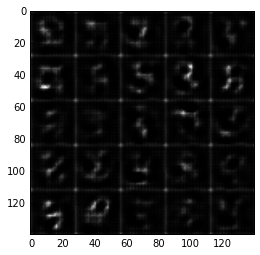

Epoch 1/2... Discriminator Loss: 1.3585... Generator Loss: 1.7517
Epoch 1/2... Discriminator Loss: 1.4618... Generator Loss: 1.7130
Epoch 1/2... Discriminator Loss: 1.4152... Generator Loss: 0.7901
Epoch 1/2... Discriminator Loss: 1.3785... Generator Loss: 0.6598
Epoch 1/2... Discriminator Loss: 1.3875... Generator Loss: 0.6641
Epoch 1/2... Discriminator Loss: 2.0467... Generator Loss: 0.2968
Epoch 1/2... Discriminator Loss: 1.2688... Generator Loss: 1.2787
Epoch 1/2... Discriminator Loss: 1.3216... Generator Loss: 0.8013
Epoch 1/2... Discriminator Loss: 1.1933... Generator Loss: 1.0712
Epoch 1/2... Discriminator Loss: 1.1977... Generator Loss: 1.5481


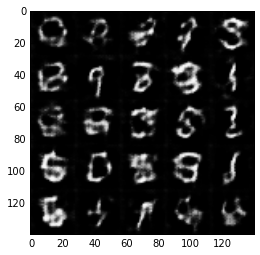

Epoch 1/2... Discriminator Loss: 1.3073... Generator Loss: 0.7324
Epoch 1/2... Discriminator Loss: 1.3807... Generator Loss: 1.9729
Epoch 1/2... Discriminator Loss: 1.2430... Generator Loss: 0.8271
Epoch 1/2... Discriminator Loss: 1.4414... Generator Loss: 0.6114
Epoch 1/2... Discriminator Loss: 1.3832... Generator Loss: 0.6261
Epoch 1/2... Discriminator Loss: 1.2697... Generator Loss: 0.8703
Epoch 1/2... Discriminator Loss: 1.2653... Generator Loss: 0.8501
Epoch 1/2... Discriminator Loss: 1.6331... Generator Loss: 0.4699
Epoch 1/2... Discriminator Loss: 1.4619... Generator Loss: 0.5655
Epoch 1/2... Discriminator Loss: 1.2708... Generator Loss: 0.9457


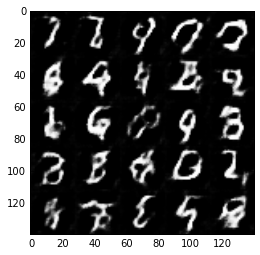

Epoch 1/2... Discriminator Loss: 1.1198... Generator Loss: 1.3524
Epoch 1/2... Discriminator Loss: 1.3855... Generator Loss: 0.6880
Epoch 1/2... Discriminator Loss: 1.4864... Generator Loss: 0.6128
Epoch 1/2... Discriminator Loss: 1.5528... Generator Loss: 0.5078
Epoch 1/2... Discriminator Loss: 1.1918... Generator Loss: 1.1059
Epoch 1/2... Discriminator Loss: 1.3733... Generator Loss: 0.7541
Epoch 1/2... Discriminator Loss: 1.2370... Generator Loss: 1.4228
Epoch 1/2... Discriminator Loss: 1.3270... Generator Loss: 0.7319
Epoch 1/2... Discriminator Loss: 1.3872... Generator Loss: 0.6133
Epoch 1/2... Discriminator Loss: 1.6976... Generator Loss: 0.4236


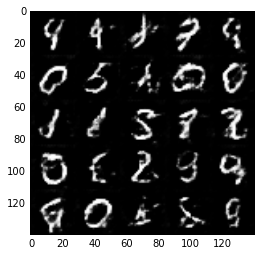

Epoch 1/2... Discriminator Loss: 1.0997... Generator Loss: 1.1533
Epoch 1/2... Discriminator Loss: 1.3717... Generator Loss: 0.6853
Epoch 1/2... Discriminator Loss: 1.3172... Generator Loss: 1.6151
Epoch 1/2... Discriminator Loss: 1.1646... Generator Loss: 1.4934
Epoch 1/2... Discriminator Loss: 1.2682... Generator Loss: 1.4302
Epoch 1/2... Discriminator Loss: 1.4756... Generator Loss: 1.9244
Epoch 1/2... Discriminator Loss: 1.5208... Generator Loss: 0.5370
Epoch 1/2... Discriminator Loss: 1.6081... Generator Loss: 2.3346
Epoch 1/2... Discriminator Loss: 1.5618... Generator Loss: 0.4970
Epoch 1/2... Discriminator Loss: 1.5953... Generator Loss: 2.2539


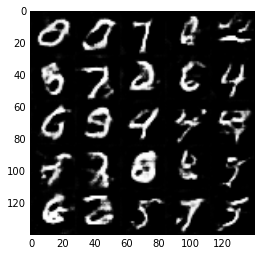

Epoch 1/2... Discriminator Loss: 1.2478... Generator Loss: 0.8247
Epoch 1/2... Discriminator Loss: 1.7066... Generator Loss: 0.4708
Epoch 1/2... Discriminator Loss: 1.3286... Generator Loss: 1.6057
Epoch 1/2... Discriminator Loss: 1.6063... Generator Loss: 0.4772
Epoch 1/2... Discriminator Loss: 1.2943... Generator Loss: 0.7396
Epoch 1/2... Discriminator Loss: 1.2657... Generator Loss: 0.7185
Epoch 1/2... Discriminator Loss: 1.3177... Generator Loss: 0.6974
Epoch 1/2... Discriminator Loss: 1.1656... Generator Loss: 1.5022
Epoch 1/2... Discriminator Loss: 1.4426... Generator Loss: 2.2120
Epoch 1/2... Discriminator Loss: 0.9514... Generator Loss: 1.3938


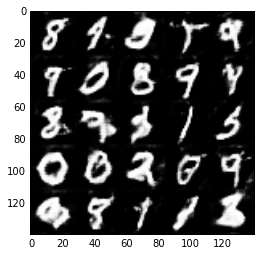

Epoch 2/2... Discriminator Loss: 1.1921... Generator Loss: 0.9599
Epoch 2/2... Discriminator Loss: 1.1862... Generator Loss: 1.0887
Epoch 2/2... Discriminator Loss: 1.1828... Generator Loss: 1.5535
Epoch 2/2... Discriminator Loss: 1.1542... Generator Loss: 1.4775
Epoch 2/2... Discriminator Loss: 1.5421... Generator Loss: 0.5403
Epoch 2/2... Discriminator Loss: 1.1844... Generator Loss: 1.1367
Epoch 2/2... Discriminator Loss: 1.3798... Generator Loss: 1.7283
Epoch 2/2... Discriminator Loss: 1.2457... Generator Loss: 1.0492
Epoch 2/2... Discriminator Loss: 1.1817... Generator Loss: 1.4773
Epoch 2/2... Discriminator Loss: 1.1153... Generator Loss: 1.2971


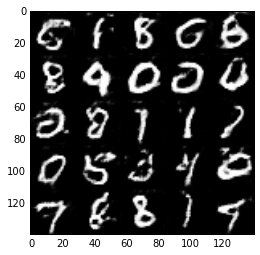

Epoch 2/2... Discriminator Loss: 1.1981... Generator Loss: 0.9611
Epoch 2/2... Discriminator Loss: 1.2633... Generator Loss: 0.9966
Epoch 2/2... Discriminator Loss: 1.5649... Generator Loss: 0.5102
Epoch 2/2... Discriminator Loss: 1.1173... Generator Loss: 1.1265
Epoch 2/2... Discriminator Loss: 1.4662... Generator Loss: 0.5655
Epoch 2/2... Discriminator Loss: 1.1625... Generator Loss: 0.9858
Epoch 2/2... Discriminator Loss: 1.2588... Generator Loss: 0.9796
Epoch 2/2... Discriminator Loss: 1.2471... Generator Loss: 0.8109
Epoch 2/2... Discriminator Loss: 1.2609... Generator Loss: 0.7711
Epoch 2/2... Discriminator Loss: 1.0697... Generator Loss: 1.3444


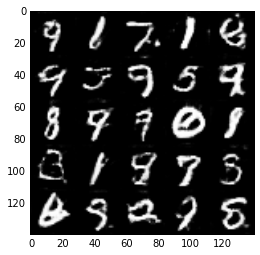

Epoch 2/2... Discriminator Loss: 1.1921... Generator Loss: 1.7630
Epoch 2/2... Discriminator Loss: 1.5409... Generator Loss: 2.4183
Epoch 2/2... Discriminator Loss: 1.2247... Generator Loss: 0.8267
Epoch 2/2... Discriminator Loss: 1.1816... Generator Loss: 1.0644
Epoch 2/2... Discriminator Loss: 1.2249... Generator Loss: 0.8470
Epoch 2/2... Discriminator Loss: 1.2596... Generator Loss: 1.6016
Epoch 2/2... Discriminator Loss: 1.3742... Generator Loss: 0.6357
Epoch 2/2... Discriminator Loss: 1.2087... Generator Loss: 1.1653
Epoch 2/2... Discriminator Loss: 1.1910... Generator Loss: 0.9536
Epoch 2/2... Discriminator Loss: 1.7278... Generator Loss: 0.4346


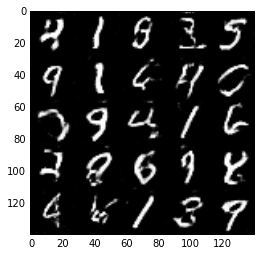

Epoch 2/2... Discriminator Loss: 1.1653... Generator Loss: 1.6815
Epoch 2/2... Discriminator Loss: 1.1897... Generator Loss: 0.9787
Epoch 2/2... Discriminator Loss: 1.0350... Generator Loss: 1.3456
Epoch 2/2... Discriminator Loss: 1.3382... Generator Loss: 0.7607
Epoch 2/2... Discriminator Loss: 1.3140... Generator Loss: 1.9378
Epoch 2/2... Discriminator Loss: 1.4871... Generator Loss: 0.5790
Epoch 2/2... Discriminator Loss: 1.3949... Generator Loss: 0.6615
Epoch 2/2... Discriminator Loss: 1.1860... Generator Loss: 0.9829
Epoch 2/2... Discriminator Loss: 1.2061... Generator Loss: 0.8544
Epoch 2/2... Discriminator Loss: 1.3101... Generator Loss: 0.7203


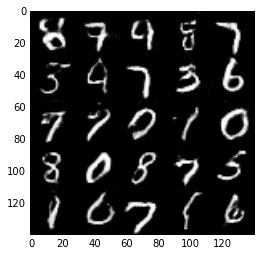

Epoch 2/2... Discriminator Loss: 1.0472... Generator Loss: 1.5252
Epoch 2/2... Discriminator Loss: 1.1762... Generator Loss: 0.9425
Epoch 2/2... Discriminator Loss: 1.0783... Generator Loss: 1.2415
Epoch 2/2... Discriminator Loss: 1.8905... Generator Loss: 2.9707
Epoch 2/2... Discriminator Loss: 1.3688... Generator Loss: 0.7099
Epoch 2/2... Discriminator Loss: 1.3061... Generator Loss: 1.1258
Epoch 2/2... Discriminator Loss: 1.0960... Generator Loss: 1.1110
Epoch 2/2... Discriminator Loss: 1.1511... Generator Loss: 1.2272
Epoch 2/2... Discriminator Loss: 1.1816... Generator Loss: 0.9629
Epoch 2/2... Discriminator Loss: 1.2579... Generator Loss: 2.1777


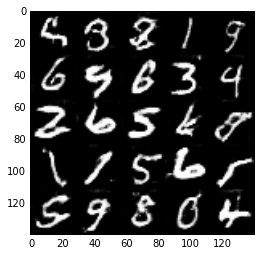

Epoch 2/2... Discriminator Loss: 1.4719... Generator Loss: 0.6179
Epoch 2/2... Discriminator Loss: 1.6858... Generator Loss: 0.5070
Epoch 2/2... Discriminator Loss: 1.3886... Generator Loss: 0.6794
Epoch 2/2... Discriminator Loss: 1.3297... Generator Loss: 0.7153
Epoch 2/2... Discriminator Loss: 1.4047... Generator Loss: 0.6995
Epoch 2/2... Discriminator Loss: 1.3506... Generator Loss: 2.6372
Epoch 2/2... Discriminator Loss: 1.3189... Generator Loss: 0.6959
Epoch 2/2... Discriminator Loss: 1.1188... Generator Loss: 1.0878
Epoch 2/2... Discriminator Loss: 1.3061... Generator Loss: 2.0785
Epoch 2/2... Discriminator Loss: 0.8831... Generator Loss: 1.5936


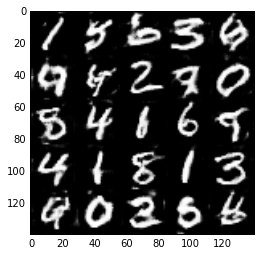

In [152]:
batch_size = 100
z_dim = 100
learning_rate = 0.003   # super aggressive
beta1 = 0.45    # experimenting...


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.9784... Generator Loss: 2.7495
Epoch 1/1... Discriminator Loss: 2.1104... Generator Loss: 0.3565
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 2.6933
Epoch 1/1... Discriminator Loss: 1.2607... Generator Loss: 1.2807
Epoch 1/1... Discriminator Loss: 1.2303... Generator Loss: 2.3768
Epoch 1/1... Discriminator Loss: 1.2723... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 0.9631
Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.8532
Epoch 1/1... Discriminator Loss: 1.1988... Generator Loss: 1.2550
Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 0.8203


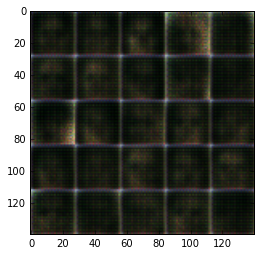

Epoch 1/1... Discriminator Loss: 1.5404... Generator Loss: 2.1071
Epoch 1/1... Discriminator Loss: 1.7592... Generator Loss: 0.4686
Epoch 1/1... Discriminator Loss: 1.1241... Generator Loss: 1.2377
Epoch 1/1... Discriminator Loss: 1.3156... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 1.8746... Generator Loss: 0.3597
Epoch 1/1... Discriminator Loss: 1.1836... Generator Loss: 1.0332
Epoch 1/1... Discriminator Loss: 1.4566... Generator Loss: 1.8396
Epoch 1/1... Discriminator Loss: 1.9022... Generator Loss: 0.3379
Epoch 1/1... Discriminator Loss: 1.1250... Generator Loss: 1.3142
Epoch 1/1... Discriminator Loss: 1.3043... Generator Loss: 0.7901


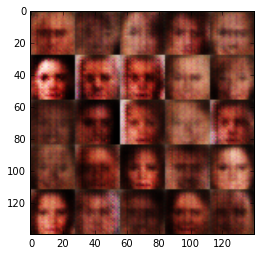

Epoch 1/1... Discriminator Loss: 1.2819... Generator Loss: 1.5925
Epoch 1/1... Discriminator Loss: 1.1813... Generator Loss: 2.0736
Epoch 1/1... Discriminator Loss: 1.1571... Generator Loss: 1.3278
Epoch 1/1... Discriminator Loss: 1.1375... Generator Loss: 1.6251
Epoch 1/1... Discriminator Loss: 1.2846... Generator Loss: 0.9527
Epoch 1/1... Discriminator Loss: 1.3700... Generator Loss: 1.4588
Epoch 1/1... Discriminator Loss: 1.1590... Generator Loss: 1.0805
Epoch 1/1... Discriminator Loss: 1.1746... Generator Loss: 1.0927
Epoch 1/1... Discriminator Loss: 1.2070... Generator Loss: 1.0685
Epoch 1/1... Discriminator Loss: 1.6489... Generator Loss: 2.4049


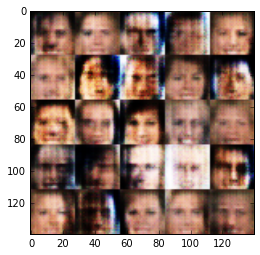

Epoch 1/1... Discriminator Loss: 1.2128... Generator Loss: 2.2110
Epoch 1/1... Discriminator Loss: 1.4784... Generator Loss: 0.5818
Epoch 1/1... Discriminator Loss: 1.2622... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 1.6038... Generator Loss: 0.4732
Epoch 1/1... Discriminator Loss: 1.2459... Generator Loss: 0.7362
Epoch 1/1... Discriminator Loss: 1.2204... Generator Loss: 0.9150
Epoch 1/1... Discriminator Loss: 1.9507... Generator Loss: 0.3104
Epoch 1/1... Discriminator Loss: 1.2296... Generator Loss: 1.1417
Epoch 1/1... Discriminator Loss: 1.1643... Generator Loss: 1.2298
Epoch 1/1... Discriminator Loss: 1.1582... Generator Loss: 2.1825


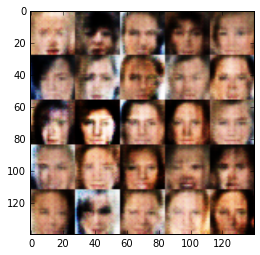

Epoch 1/1... Discriminator Loss: 0.9872... Generator Loss: 1.2473
Epoch 1/1... Discriminator Loss: 1.1936... Generator Loss: 1.1649
Epoch 1/1... Discriminator Loss: 1.2009... Generator Loss: 0.9341
Epoch 1/1... Discriminator Loss: 1.2612... Generator Loss: 2.7598
Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 1.0895
Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 0.8576
Epoch 1/1... Discriminator Loss: 1.0232... Generator Loss: 1.5739
Epoch 1/1... Discriminator Loss: 1.0719... Generator Loss: 1.1615
Epoch 1/1... Discriminator Loss: 1.0983... Generator Loss: 1.4913
Epoch 1/1... Discriminator Loss: 1.5118... Generator Loss: 0.5464


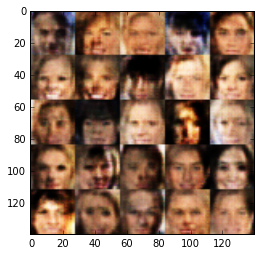

Epoch 1/1... Discriminator Loss: 1.1925... Generator Loss: 0.9728
Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 1.1338... Generator Loss: 1.1278
Epoch 1/1... Discriminator Loss: 1.2404... Generator Loss: 0.9770
Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 0.9887
Epoch 1/1... Discriminator Loss: 1.1846... Generator Loss: 1.3361
Epoch 1/1... Discriminator Loss: 1.4505... Generator Loss: 2.4973
Epoch 1/1... Discriminator Loss: 0.9130... Generator Loss: 2.0380
Epoch 1/1... Discriminator Loss: 1.6942... Generator Loss: 2.9217
Epoch 1/1... Discriminator Loss: 1.2176... Generator Loss: 0.8794


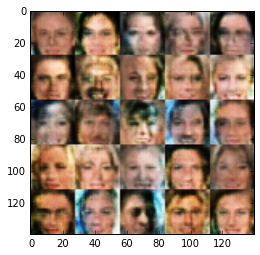

Epoch 1/1... Discriminator Loss: 1.2108... Generator Loss: 1.2031
Epoch 1/1... Discriminator Loss: 0.8660... Generator Loss: 2.6282
Epoch 1/1... Discriminator Loss: 1.2389... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 1.3154... Generator Loss: 2.4258
Epoch 1/1... Discriminator Loss: 1.1780... Generator Loss: 1.9619
Epoch 1/1... Discriminator Loss: 1.2094... Generator Loss: 1.4801
Epoch 1/1... Discriminator Loss: 1.8899... Generator Loss: 0.3316
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 0.9106
Epoch 1/1... Discriminator Loss: 1.1676... Generator Loss: 1.2839
Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.7069


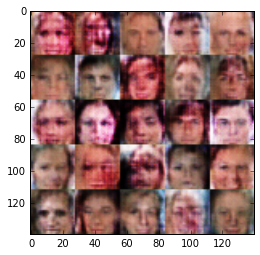

Epoch 1/1... Discriminator Loss: 1.1147... Generator Loss: 1.1524
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 2.2080
Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 0.7024
Epoch 1/1... Discriminator Loss: 1.0305... Generator Loss: 1.1901
Epoch 1/1... Discriminator Loss: 1.2138... Generator Loss: 0.9783
Epoch 1/1... Discriminator Loss: 1.0933... Generator Loss: 1.3197
Epoch 1/1... Discriminator Loss: 1.2381... Generator Loss: 0.8968
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.6469
Epoch 1/1... Discriminator Loss: 1.0831... Generator Loss: 1.2411
Epoch 1/1... Discriminator Loss: 1.1921... Generator Loss: 0.8931


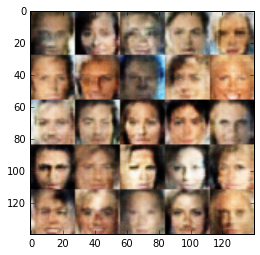

Epoch 1/1... Discriminator Loss: 1.1007... Generator Loss: 1.3638
Epoch 1/1... Discriminator Loss: 1.2102... Generator Loss: 1.1239
Epoch 1/1... Discriminator Loss: 1.2675... Generator Loss: 0.7485
Epoch 1/1... Discriminator Loss: 1.2174... Generator Loss: 0.8487
Epoch 1/1... Discriminator Loss: 1.5104... Generator Loss: 2.2664
Epoch 1/1... Discriminator Loss: 1.2261... Generator Loss: 1.4010
Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 1.8780
Epoch 1/1... Discriminator Loss: 1.2601... Generator Loss: 0.8507
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 2.2396
Epoch 1/1... Discriminator Loss: 1.1550... Generator Loss: 0.9606


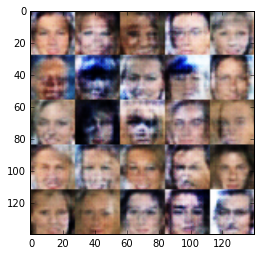

Epoch 1/1... Discriminator Loss: 1.0907... Generator Loss: 1.0028
Epoch 1/1... Discriminator Loss: 1.6516... Generator Loss: 0.4532
Epoch 1/1... Discriminator Loss: 1.2320... Generator Loss: 1.0980
Epoch 1/1... Discriminator Loss: 1.0890... Generator Loss: 1.0790
Epoch 1/1... Discriminator Loss: 1.1345... Generator Loss: 1.0587
Epoch 1/1... Discriminator Loss: 1.0541... Generator Loss: 1.3437
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 2.0483
Epoch 1/1... Discriminator Loss: 1.0607... Generator Loss: 1.0659
Epoch 1/1... Discriminator Loss: 1.0301... Generator Loss: 1.3793
Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 0.9480


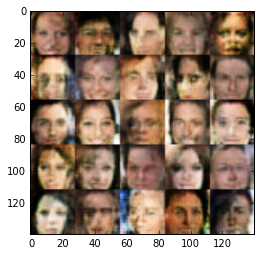

Epoch 1/1... Discriminator Loss: 1.2151... Generator Loss: 0.8395
Epoch 1/1... Discriminator Loss: 1.1475... Generator Loss: 1.3555
Epoch 1/1... Discriminator Loss: 1.1057... Generator Loss: 1.2216
Epoch 1/1... Discriminator Loss: 1.2097... Generator Loss: 0.9730
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 2.1847
Epoch 1/1... Discriminator Loss: 1.1414... Generator Loss: 1.4141
Epoch 1/1... Discriminator Loss: 1.1109... Generator Loss: 1.1917
Epoch 1/1... Discriminator Loss: 1.1151... Generator Loss: 1.1590
Epoch 1/1... Discriminator Loss: 1.4795... Generator Loss: 2.6559
Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 0.9789


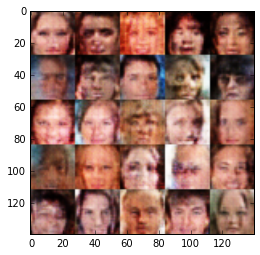

Epoch 1/1... Discriminator Loss: 1.1705... Generator Loss: 1.1103
Epoch 1/1... Discriminator Loss: 1.2136... Generator Loss: 1.0325
Epoch 1/1... Discriminator Loss: 1.0788... Generator Loss: 1.1208
Epoch 1/1... Discriminator Loss: 1.2998... Generator Loss: 1.1122
Epoch 1/1... Discriminator Loss: 1.1328... Generator Loss: 1.0176
Epoch 1/1... Discriminator Loss: 1.1762... Generator Loss: 1.2636
Epoch 1/1... Discriminator Loss: 1.6299... Generator Loss: 0.5464
Epoch 1/1... Discriminator Loss: 1.2781... Generator Loss: 0.7173
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.5972
Epoch 1/1... Discriminator Loss: 1.1543... Generator Loss: 1.2522


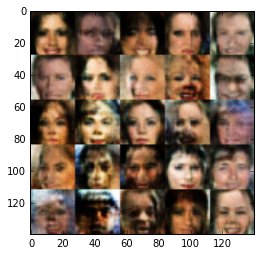

Epoch 1/1... Discriminator Loss: 1.2635... Generator Loss: 0.9840
Epoch 1/1... Discriminator Loss: 1.1395... Generator Loss: 1.0817
Epoch 1/1... Discriminator Loss: 2.0630... Generator Loss: 3.5191
Epoch 1/1... Discriminator Loss: 1.2068... Generator Loss: 0.9520
Epoch 1/1... Discriminator Loss: 1.1952... Generator Loss: 1.0585
Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 1.6077
Epoch 1/1... Discriminator Loss: 1.0674... Generator Loss: 1.1605
Epoch 1/1... Discriminator Loss: 1.1282... Generator Loss: 1.2382
Epoch 1/1... Discriminator Loss: 1.2692... Generator Loss: 0.9397
Epoch 1/1... Discriminator Loss: 1.2383... Generator Loss: 0.7976


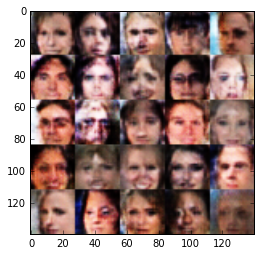

Epoch 1/1... Discriminator Loss: 1.0459... Generator Loss: 1.6598
Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 1.1816... Generator Loss: 0.8348
Epoch 1/1... Discriminator Loss: 1.5603... Generator Loss: 0.5085
Epoch 1/1... Discriminator Loss: 1.1871... Generator Loss: 0.9726
Epoch 1/1... Discriminator Loss: 1.2014... Generator Loss: 0.8432
Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 1.1891... Generator Loss: 1.4004
Epoch 1/1... Discriminator Loss: 1.1639... Generator Loss: 1.6576
Epoch 1/1... Discriminator Loss: 1.1229... Generator Loss: 1.1332


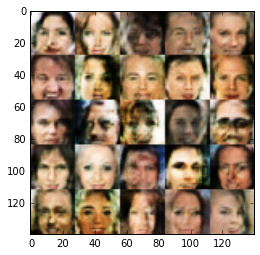

Epoch 1/1... Discriminator Loss: 1.2502... Generator Loss: 1.4953
Epoch 1/1... Discriminator Loss: 1.0386... Generator Loss: 1.1483
Epoch 1/1... Discriminator Loss: 1.1687... Generator Loss: 1.0222
Epoch 1/1... Discriminator Loss: 1.1556... Generator Loss: 1.2318
Epoch 1/1... Discriminator Loss: 1.1846... Generator Loss: 1.2852
Epoch 1/1... Discriminator Loss: 1.4587... Generator Loss: 0.5643
Epoch 1/1... Discriminator Loss: 1.0696... Generator Loss: 1.1374
Epoch 1/1... Discriminator Loss: 1.5137... Generator Loss: 0.5185
Epoch 1/1... Discriminator Loss: 1.0967... Generator Loss: 1.7430
Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 0.8862


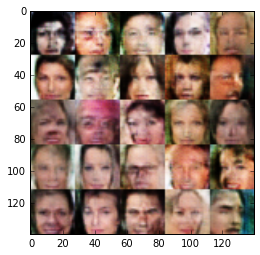

Epoch 1/1... Discriminator Loss: 1.0885... Generator Loss: 1.3294
Epoch 1/1... Discriminator Loss: 1.2271... Generator Loss: 0.9225
Epoch 1/1... Discriminator Loss: 1.1720... Generator Loss: 0.9986
Epoch 1/1... Discriminator Loss: 1.0364... Generator Loss: 1.0793
Epoch 1/1... Discriminator Loss: 1.6857... Generator Loss: 0.4149
Epoch 1/1... Discriminator Loss: 1.1540... Generator Loss: 0.9888
Epoch 1/1... Discriminator Loss: 1.2126... Generator Loss: 0.8944
Epoch 1/1... Discriminator Loss: 1.0718... Generator Loss: 1.0978
Epoch 1/1... Discriminator Loss: 1.2963... Generator Loss: 1.2706
Epoch 1/1... Discriminator Loss: 1.0962... Generator Loss: 1.1304


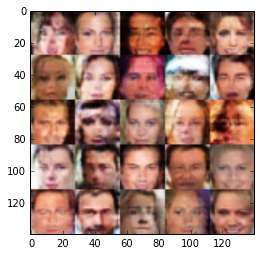

Epoch 1/1... Discriminator Loss: 1.5654... Generator Loss: 0.4979
Epoch 1/1... Discriminator Loss: 1.2526... Generator Loss: 0.8186
Epoch 1/1... Discriminator Loss: 1.0928... Generator Loss: 1.4050
Epoch 1/1... Discriminator Loss: 1.3051... Generator Loss: 0.7421
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.6413
Epoch 1/1... Discriminator Loss: 1.0938... Generator Loss: 1.0759
Epoch 1/1... Discriminator Loss: 1.1825... Generator Loss: 0.9472
Epoch 1/1... Discriminator Loss: 1.1302... Generator Loss: 1.3017
Epoch 1/1... Discriminator Loss: 1.6315... Generator Loss: 2.4698
Epoch 1/1... Discriminator Loss: 1.2957... Generator Loss: 1.1824


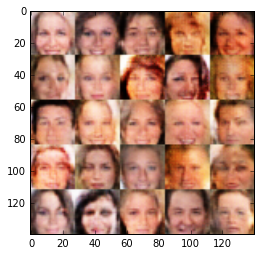

Epoch 1/1... Discriminator Loss: 1.2193... Generator Loss: 0.9324
Epoch 1/1... Discriminator Loss: 1.0665... Generator Loss: 1.2109
Epoch 1/1... Discriminator Loss: 1.2437... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 1.3349... Generator Loss: 0.7328
Epoch 1/1... Discriminator Loss: 1.1873... Generator Loss: 0.9555
Epoch 1/1... Discriminator Loss: 1.1731... Generator Loss: 0.9685
Epoch 1/1... Discriminator Loss: 1.0972... Generator Loss: 1.1096
Epoch 1/1... Discriminator Loss: 1.0338... Generator Loss: 1.2190
Epoch 1/1... Discriminator Loss: 1.0466... Generator Loss: 1.3402
Epoch 1/1... Discriminator Loss: 1.1929... Generator Loss: 0.9468


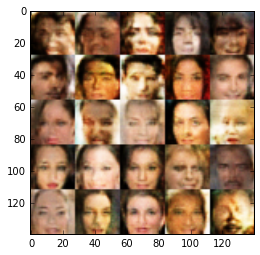

Epoch 1/1... Discriminator Loss: 1.5200... Generator Loss: 0.5043
Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 0.9775
Epoch 1/1... Discriminator Loss: 1.0626... Generator Loss: 1.4668
Epoch 1/1... Discriminator Loss: 1.2920... Generator Loss: 1.8409


In [26]:
batch_size = 110
z_dim = 100
learning_rate = 0.0003  # experimenting... what produces the most realistic faces
learning_rate = 0.00045  # experimenting... what produces the most realistic faces
beta1 = 0.45    # experimenting...


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.